Image 1	
a bird perched on a branch of a tree .	


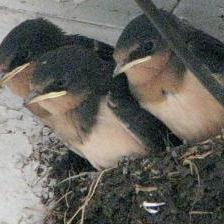

Image 2	
a woman is walking down a tennis court with a racket .	


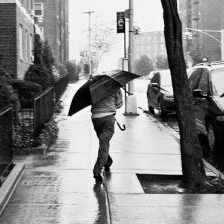

Image 3	
a man and a woman playing a video game .	


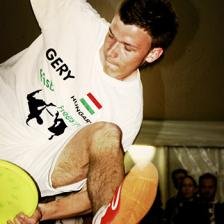

Image 4	
a man in a white shirt and a tennis racket .	


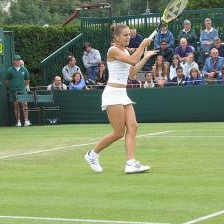

Image 5	
a television sitting on a couch in a living room .	


Image 6	


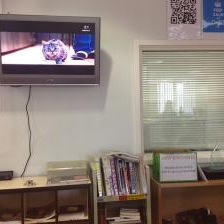

a boat is docked in the water .	


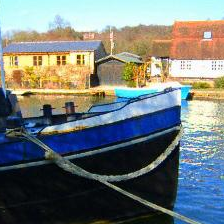

Image 7	
a bathroom with a sink and a toilet .	


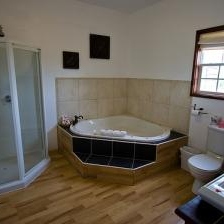

Image 8	
a young boy holding a baseball bat on her field .	


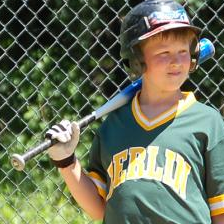

Image 9	
a baseball player swinging a bat at a ball .	


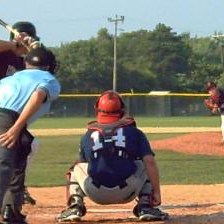

Image 10	
a street sign with a traffic light and buildings .	


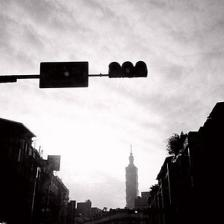

Image 11	


a group of people sitting at a table eating food .	


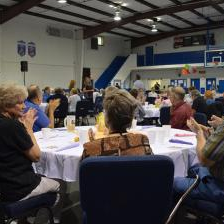

Image 12	
a laptop computer sitting on top of a desk .	


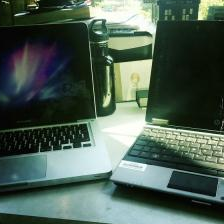

Image 13	
a man is holding a banana in a field .	


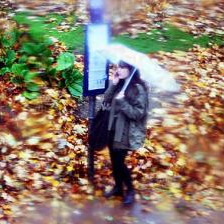

Image 14	
a clock tower with a clock tower in the background .	


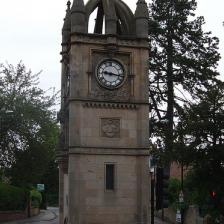

Image 15	
a suitcase with luggage on the side of a car .	


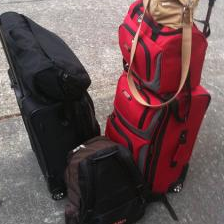

Image 16	
a group of people are standing in a field of food .	


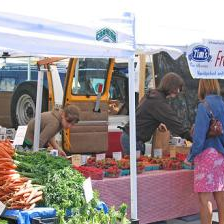

Image 17	
a bathroom with a sink and a mirror .	


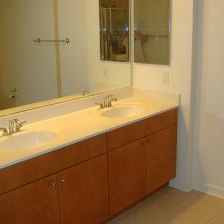

Image 18	
a man surfing on a wave in the ocean .	


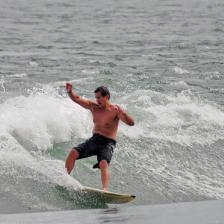

Image 19	
sheep grazing in a field of grass with a fence .	


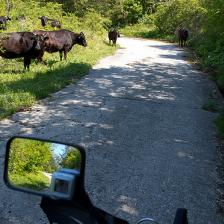

Image 20	
a man playing tennis on a tennis court .	


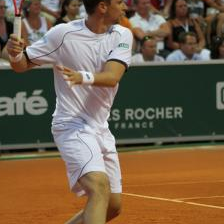

In [7]:
require 'cunn'
require 'cudnn'
require 'nngraph'
require 'recurrent'

local TrainedModel = './PreTrainedModels/captionInceptionv3.t7'
local config = require 'Config'
config.PreTrainedCNN = '../inception-v3.torch/inception_v3.net'--
config.Normalization = {'simple', 128, 128}--Inception-v3 case
config.FeatLayerCNN = 28
config.NumFeatsCNN = 2048
config.InputSize = {3,224,224}
config.SentenceLength = 10--opt.seqLength

local numImages = 20
local numWords = 15
local data =require 'Data'
local imgs = torch.ByteTensor(numImages, unpack(config.InputSize))
local caption
imgs, captions = data.ValDB:cacheSeq(Key(90),numImages, imgs)
imgs = imgs:cuda()
imgs:add(-config.Normalization[2]):div(config.Normalization[3])
local cnnModel = torch.load(config.PreTrainedCNN):cuda()
local removeAfter = config.FeatLayerCNN
for i = #cnnModel, removeAfter ,-1 do
  cnnModel:remove(i)
end
local imgNum = 1
local modelConfig = torch.load(TrainedModel)
local textEmbedder = modelConfig.textEmbedder:cuda()
local imageEmbedder = modelConfig.imageEmbedder:cuda()
local classifier = modelConfig.classifier:cuda()
local recurrent = modelConfig.recurrent:cuda()
local model = nn.Sequential():add(recurrent):add(classifier)
local inputSize = modelConfig.inputSize
local vocab = config.Vocab
local decoder = data.decoder

model:evaluate()
imageEmbedder:evaluate()
textEmbedder:evaluate()
cnnModel:evaluate()
local temperature = 0--temperature or 1

recurrent:evaluate()
recurrent:single()
local numVecs = torch.IntTensor(numImages, numWords):zero()
local imageRep = cnnModel:forward(imgs)
local embeddedImg = imageEmbedder:forward(imageRep):squeeze()

model:zeroState()
local pred = model:forward(embeddedImg)
local _, wordNums = pred:max(2)

for j=1, numWords do
  numVecs:select(2,j):copy(wordNums)
  embedded = textEmbedder:forward(wordNums):squeeze()
  pred = model:forward(embedded)
  _, wordNums = pred:max(2)
end

for i=1, numImages do
  print('Image ' .. i)
  print(decode(numVecs[i], vocab['.']))
  itorch.image(imgs[i])
end
